In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'ZEIT ONLINE',
    'Der Tagesspiegel',
    'ARD',
    'tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(input_string.split()):
            upper_bound = len(input_string.split())
        output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_avg_sentiment_df(input_df):
    avg_pos = input_df[input_df['positive']].groupby(['medium'])['score'].median()
    avg_neu = input_df[input_df['neutral']].groupby(['medium'])['score'].median()
    avg_neg = input_df[input_df['negative']].groupby(['medium'])['score'].median()
    output_df = pd.DataFrame(data={'avg_pos':avg_pos, 'avg_neu':avg_neu, 'avg_neg':avg_neg})
    return output_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_avg_party_sentiment(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_avg_sentiment_df(df)
    return df['avg_pos'], df['avg_neu'], df['avg_neg']

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [19]:
skip_computation = True

df = pd.read_pickle('../data/topics_combined.pkl')
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)

tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [9]:
test = 'Olaf Scholz hielt keine Rede im Bundestag'
print(f"classification: {classifier(test)}")

classification: [{'label': 'neutral', 'score': 0.9586658477783203}]


In [10]:
ind = 2
party = 'spd'
n_words = 20

subset = 'contains_' + party
teststring = df.loc[df[subset]].iloc[ind]['preprocessed']
extracted_strings = extract_party_mentions(input_string=teststring, party_strings=search_terms[party], n_words=n_words)
print(f'Strings: {extracted_strings}')
print(f'Classification: {classifier(extracted_strings)}')

Strings: ['hören zusammenfasse thema klimaschutz gehört abschließenden blick gerne grünen koalition gegangen unterstützt krieg kosovo gefleddert rausgegangen dauerte glaube partei grünen spd erholt glauben passieren reemtsma deutlich deutlich verfehlt eindruck entsteht grünen ideale aufgegeben einschätzung']
Classification: [{'label': 'negative', 'score': 0.8417817950248718}]


In [11]:
if skip_computation:
    pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_df.pkl')
    neu_counts_df = pd.read_pickle('../data/sentiment/neu_counts_df.pkl')
    neg_counts_df = pd.read_pickle('../data/sentiment/neg_counts_df.pkl')
else:
    pos_counts_dict = {}
    neu_counts_dict = {}
    neg_counts_dict = {}
    for party in search_terms.keys():
        pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

    pos_counts_df = pd.DataFrame(pos_counts_dict)
    pos_counts_df = pos_counts_df.loc[media]
    pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neu_counts_df = pd.DataFrame(neu_counts_dict)
    neu_counts_df = neu_counts_df.loc[media]
    neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neg_counts_df = pd.DataFrame(neg_counts_dict)
    neg_counts_df = neg_counts_df.loc[media]
    neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

    pos_counts_df.to_pickle('../data/sentiment/pos_counts_df.pkl')
    neu_counts_df.to_pickle('../data/sentiment/neu_counts_df.pkl')
    neg_counts_df.to_pickle('../data/sentiment/neg_counts_df.pkl')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium and party, standardized')]

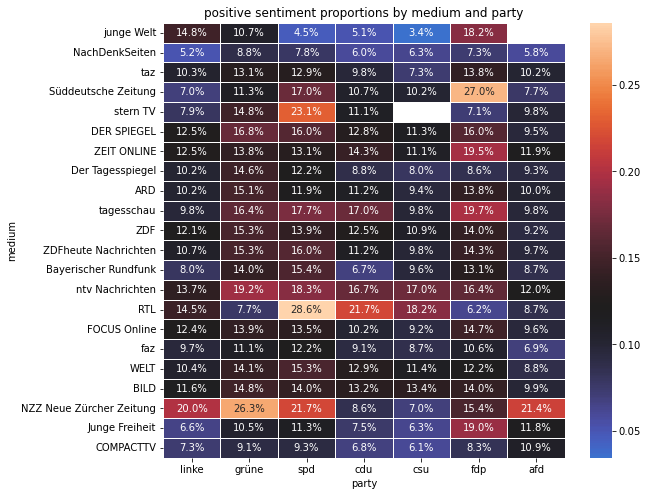

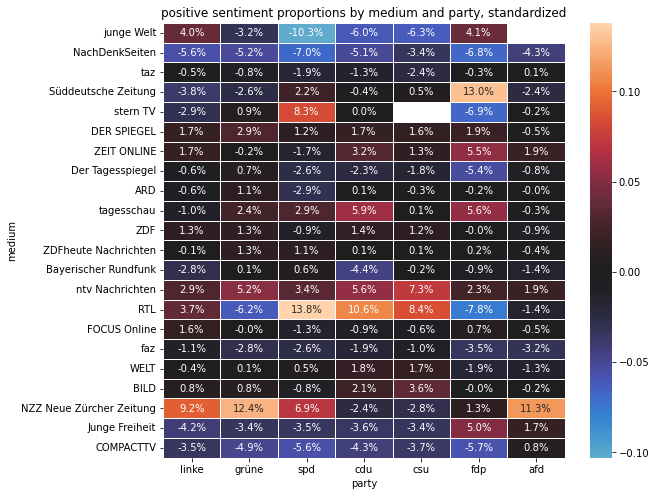

In [12]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        pos.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')

In [13]:
print(f"positive sentiment means:\n{pos.mean()}\n\npositive sentiment standard deviation:\n{pos.std()}")

positive sentiment means:
linke    0.107894
grüne    0.139274
spd      0.148114
cdu      0.110906
csu      0.097438
fdp      0.140599
afd      0.100801
dtype: float64

positive sentiment standard deviation:
linke    0.033024
grüne    0.039563
spd      0.051778
cdu      0.039840
csu      0.034718
fdp      0.049604
afd      0.030122
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium and party, standardized')]

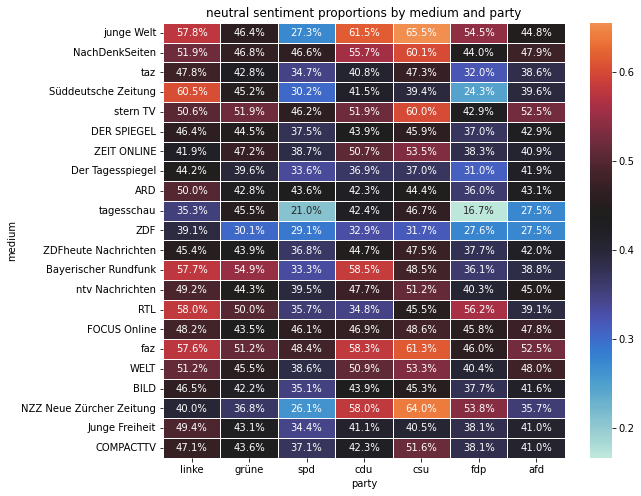

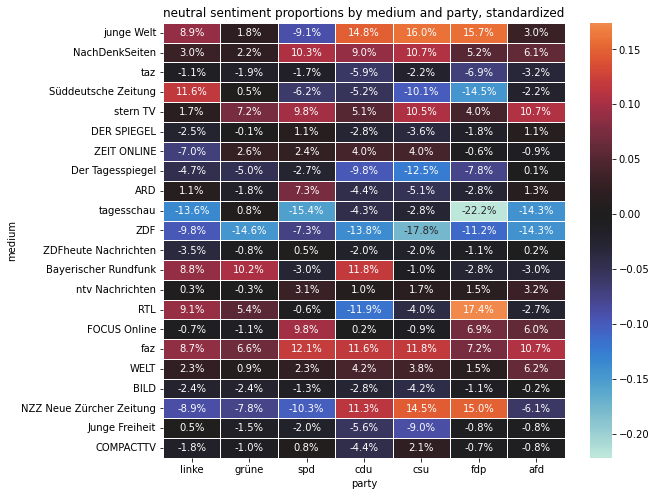

In [14]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neu.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')

In [15]:
print(f"neutral sentiment means:\n{neu.mean()}\n\nneutral sentiment standard deviation:\n{neu.std()}")

neutral sentiment means:
linke    0.488968
grüne    0.446305
spd      0.363486
cdu      0.467072
csu      0.494946
fdp      0.388496
afd      0.417948
dtype: float64

neutral sentiment standard deviation:
linke    0.066478
grüne    0.051728
spd      0.071023
cdu      0.080556
csu      0.087666
fdp      0.094647
afd      0.063323
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium and party, standardized')]

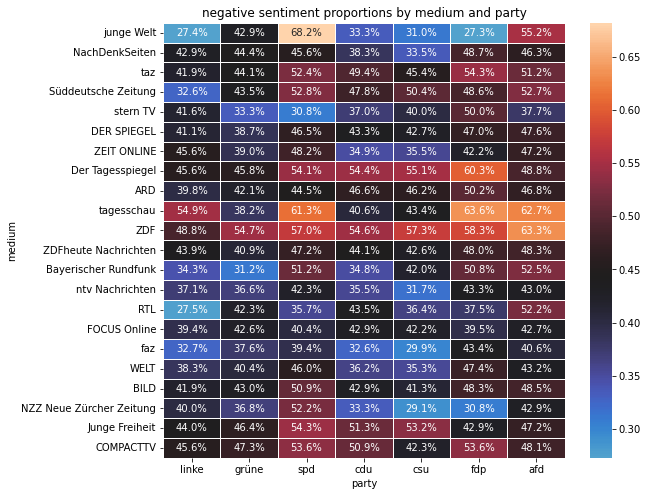

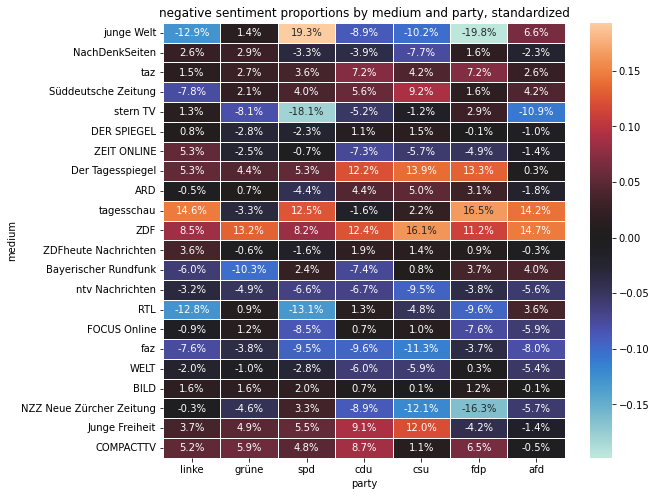

In [16]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neg.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')

In [17]:
print(f"negative sentiment means:\n{neg.mean()}\n\nnegative sentiment standard deviation:\n{neg.std()}")

negative sentiment means:
linke    0.403138
grüne    0.414421
spd      0.488400
cdu      0.422022
csu      0.412045
fdp      0.470905
afd      0.485833
dtype: float64

negative sentiment standard deviation:
linke    0.065790
grüne    0.050561
spd      0.083845
cdu      0.070853
csu      0.080264
fdp      0.086932
afd      0.063152
dtype: float64


In [18]:
for sent, df in dict(zip(['pos', 'neu', 'neg'],[pos, neu, neg])).items():
    export_df = df.copy(deep=True)
    export_df = df.loc[media].drop('tagesschau')[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
    export_df.to_pickle(f'../data/sentiment/{sent}.pkl')

    export_df_mwf = df.copy(deep=True)
    export_df_mwf = standardize_df(df).loc[media].drop('tagesschau')[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
    export_df_mwf.to_pickle(f'../data/sentiment/{sent}_mittelwertfrei.pkl')